In [1]:
import sys

In [2]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime

%matplotlib inline

In [3]:
api_key = "pCRLPdf2lkjpRX9Uczpt2gVBb" 
api_secret = "G1Wv7sTLMYF3cr5LbL8S9uj2g2LFrdWp8X8t7Ft3sIpW0kbqgD" 
access_token = "100875722-7m5vhOzpw2LYrB7P8ISnTqtGYMMvVTqwx3X4EyJY" 
access_token_secret = "uPEymGiszhiJEVWD4Alo1pzMUJx1ymo3Fd4HWyRPRBN3r" 

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)
col = pymongo.MongoClient()["DataWranglingDay1"]["Harris"]
col.count()

<ipython-input-3-4ece2cc6b7eb>:11: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  col.count()


5081

In [4]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=3000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        
        self.counter += 1
        
        
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
           
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=5000)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
keywords = ["Harris",""
           ]


progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)


for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

IntProgress(value=0)

HTML(value='<span class="label label-primary">Tweets/Sec: 0.0</span>')

ERROR# 1
Tweets collected: 3798
Total tweets in collection: 8879


<ipython-input-4-ea33fae95756>:55: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  print("Total tweets in collection: %s" % col.count())


In [7]:
col.find_one()

{'_id': ObjectId('5f966a1e4fcb2ccc22a7f591'),
 'created_at': 'Mon Oct 26 06:18:00 +0000 2020',
 'id': 1320610612569755648,
 'id_str': '1320610612569755648',
 'text': 'RT @makaylajwatts: Yes!',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1280540501817491456,
  'id_str': '1280540501817491456',
  'name': 'oomf',
  'screen_name': '4pe5h1t',
  'location': '17 s/h',
  'url': None,
  'description': 'BLM | alice stan account | still a personified bad acid trip',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 505,
  'friends_count': 718,
  'listed_count': 11,
  'favourites_count': 30780,
  'statuses_count': 31476,
  'created_at': 'Tue Jul 07 16:33:52 +0000 2020',
  'utc_offset': None,
  'time_zone'

In [8]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset = pd.DataFrame(dataset)

dataset

,created_at,text,user,source,lang
0,Mon Oct 26 06:18:00 +0000 2020,RT @makaylajwatts: Yes!,@4pe5h1t,"<a href=""http://twitter.com/download/iphone"" r...",und
1,Mon Oct 26 06:18:01 +0000 2020,RT @TrumpWarRoom: WATCH: CBS Norah O'Donnell r...,@wsheap,"<a href=""http://twitter.com/download/android"" ...",en
2,Mon Oct 26 06:18:01 +0000 2020,So were Biden's ancestors Slave Owners.,@jazzyjulie58,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
3,Mon Oct 26 06:18:01 +0000 2020,RT @SopanDeb: I missed this earlier. Observe h...,@zweidrache,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
4,Mon Oct 26 06:18:01 +0000 2020,"RT @Mike_Pence: Joe Biden, Kamala Harris and A...",@newman78540945,"<a href=""http://twitter.com/download/iphone"" r...",en
...,...,...,...,...,...
8874,Tue Oct 27 13:42:39 +0000 2020,RT @JIMMMYUSA: Please change your vote ASAP \n...,@onceayankee55,"<a href=""http://twitter.com/download/iphone"" r...",en
8875,Tue Oct 27 13:42:39 +0000 2020,RT @LisaMarieBoothe: Kamala Harris scares me m...,@Dru_Stl,"<a href=""http://twitter.com/download/iphone"" r...",en
8876,Tue Oct 27 13:42:40 +0000 2020,"RT @marklevinshow: Kamala Harris, liar\nhttps:...",@stbythec,"<a href=""http://twitter.com/download/iphone"" r...",in
8877,Tue Oct 27 13:42:40 +0000 2020,RT @rosemcgowan: We have more power than YOU @...,@Sunstruk,"<a href=""http://twitter.com/download/iphone"" r...",en


In [9]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,rt,7038
1,harris,5049
2,kamala,4884
3,the,3425
4,https,2735
5,co,2678
6,to,2555
7,is,2426
8,she,2188
9,biden,1838


<ipython-input-10-a8481ec67a37>:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset.source_name = dataset.source.apply(get_source_name)


Echofon                   4
WordPress.com             7
dlvr.it                   9
Tweetbot for iΟS         10
IFTTT                    16
TweetDeck                23
Twitter for iPad        635
Twitter Web App        2023
Twitter for Android    2688
Twitter for iPhone     3395
Name: source, dtype: int64

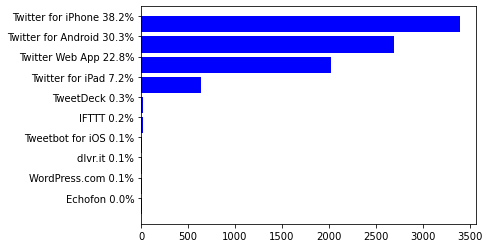

In [10]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="blue", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts

eu        9
zh       13
pt       15
fr       58
es       74
tl      127
in      133
de      210
und     535
en     7650
Name: lang, dtype: int64

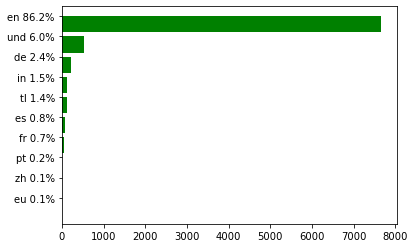

In [11]:
lang_counts = dataset.lang.value_counts().sort_values()[-10:]
bottom = [index for index, item in enumerate(lang_counts.index)]
plt.barh(bottom, width=lang_counts, color="green", linewidth=0)
y_labels = ["%s %.1f%%" % (item, 100.0*lang_counts[item]/len(dataset)) for index,item in enumerate(lang_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
lang_counts

In [12]:
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from  textblob import TextBlob

In [13]:
dataset1 = [{"id": item["id"],
            "text": item["text"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset1 = pd.DataFrame(dataset1)

is_dataset1=dataset1.lang=="en"
dataset1=dataset1[is_dataset1]
dataset1

,id,text,lang
1,1320610615455588355,RT @TrumpWarRoom: WATCH: CBS Norah O'Donnell r...,en
2,1320610615975530498,So were Biden's ancestors Slave Owners.,en
3,1320610616655122432,RT @SopanDeb: I missed this earlier. Observe h...,en
4,1320610618399809538,"RT @Mike_Pence: Joe Biden, Kamala Harris and A...",en
5,1320610618655657984,RT @hasanthehun: i cannot think of a worse way...,en
...,...,...,...
8873,1321084899902791685,“They’re not gonna stop.”\n\nKamala Harris,en
8874,1321084902293540865,RT @JIMMMYUSA: Please change your vote ASAP \n...,en
8875,1321084902478127104,RT @LisaMarieBoothe: Kamala Harris scares me m...,en
8877,1321084904487088133,RT @rosemcgowan: We have more power than YOU @...,en


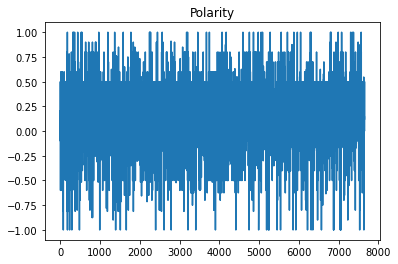

In [14]:
tweettext=dataset1['text']
wordlist=pd.DataFrame();

polarity=[]
subj=[]

for t in tweettext:
    tx= TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

poltweet= pd.DataFrame({'polarity':polarity,'subjectivity':subj})
poltweet.polarity.plot(title='Polarity')
plt.show()

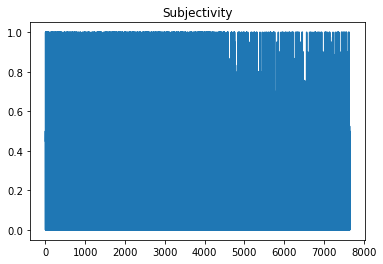

In [15]:
poltweet.subjectivity.plot(title='Subjectivity')
plt.show()

In [16]:
import statistics
statistics.mean(poltweet.polarity)

0.07514016056685181

In [17]:
import statistics
statistics.mean(poltweet.subjectivity)

0.34947155417593095

In [18]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [19]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
top_N = 100


a = dataset1['text'].str.lower().str.cat(sep=' ')


b = re.sub('[^A-Za-z]+', ' ', a)
nltk.download('stopwords')
nltk.download('punkt')
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


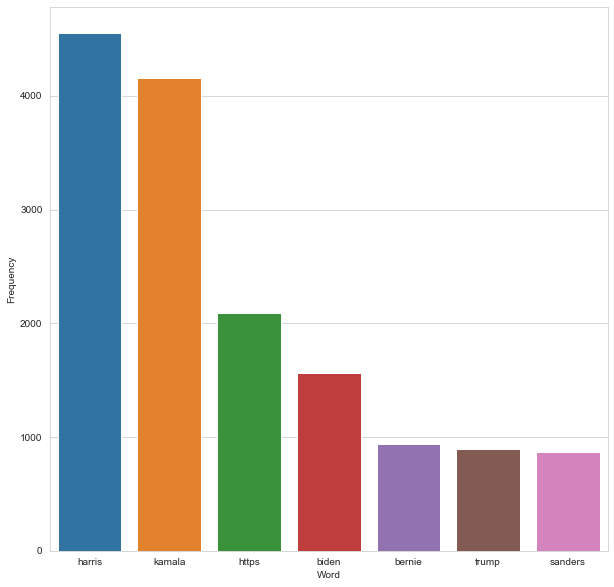

In [20]:
import seaborn as sns
 
without_single_chr = [word for word in filtered_sentence if len(word) > 2]


cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        


word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

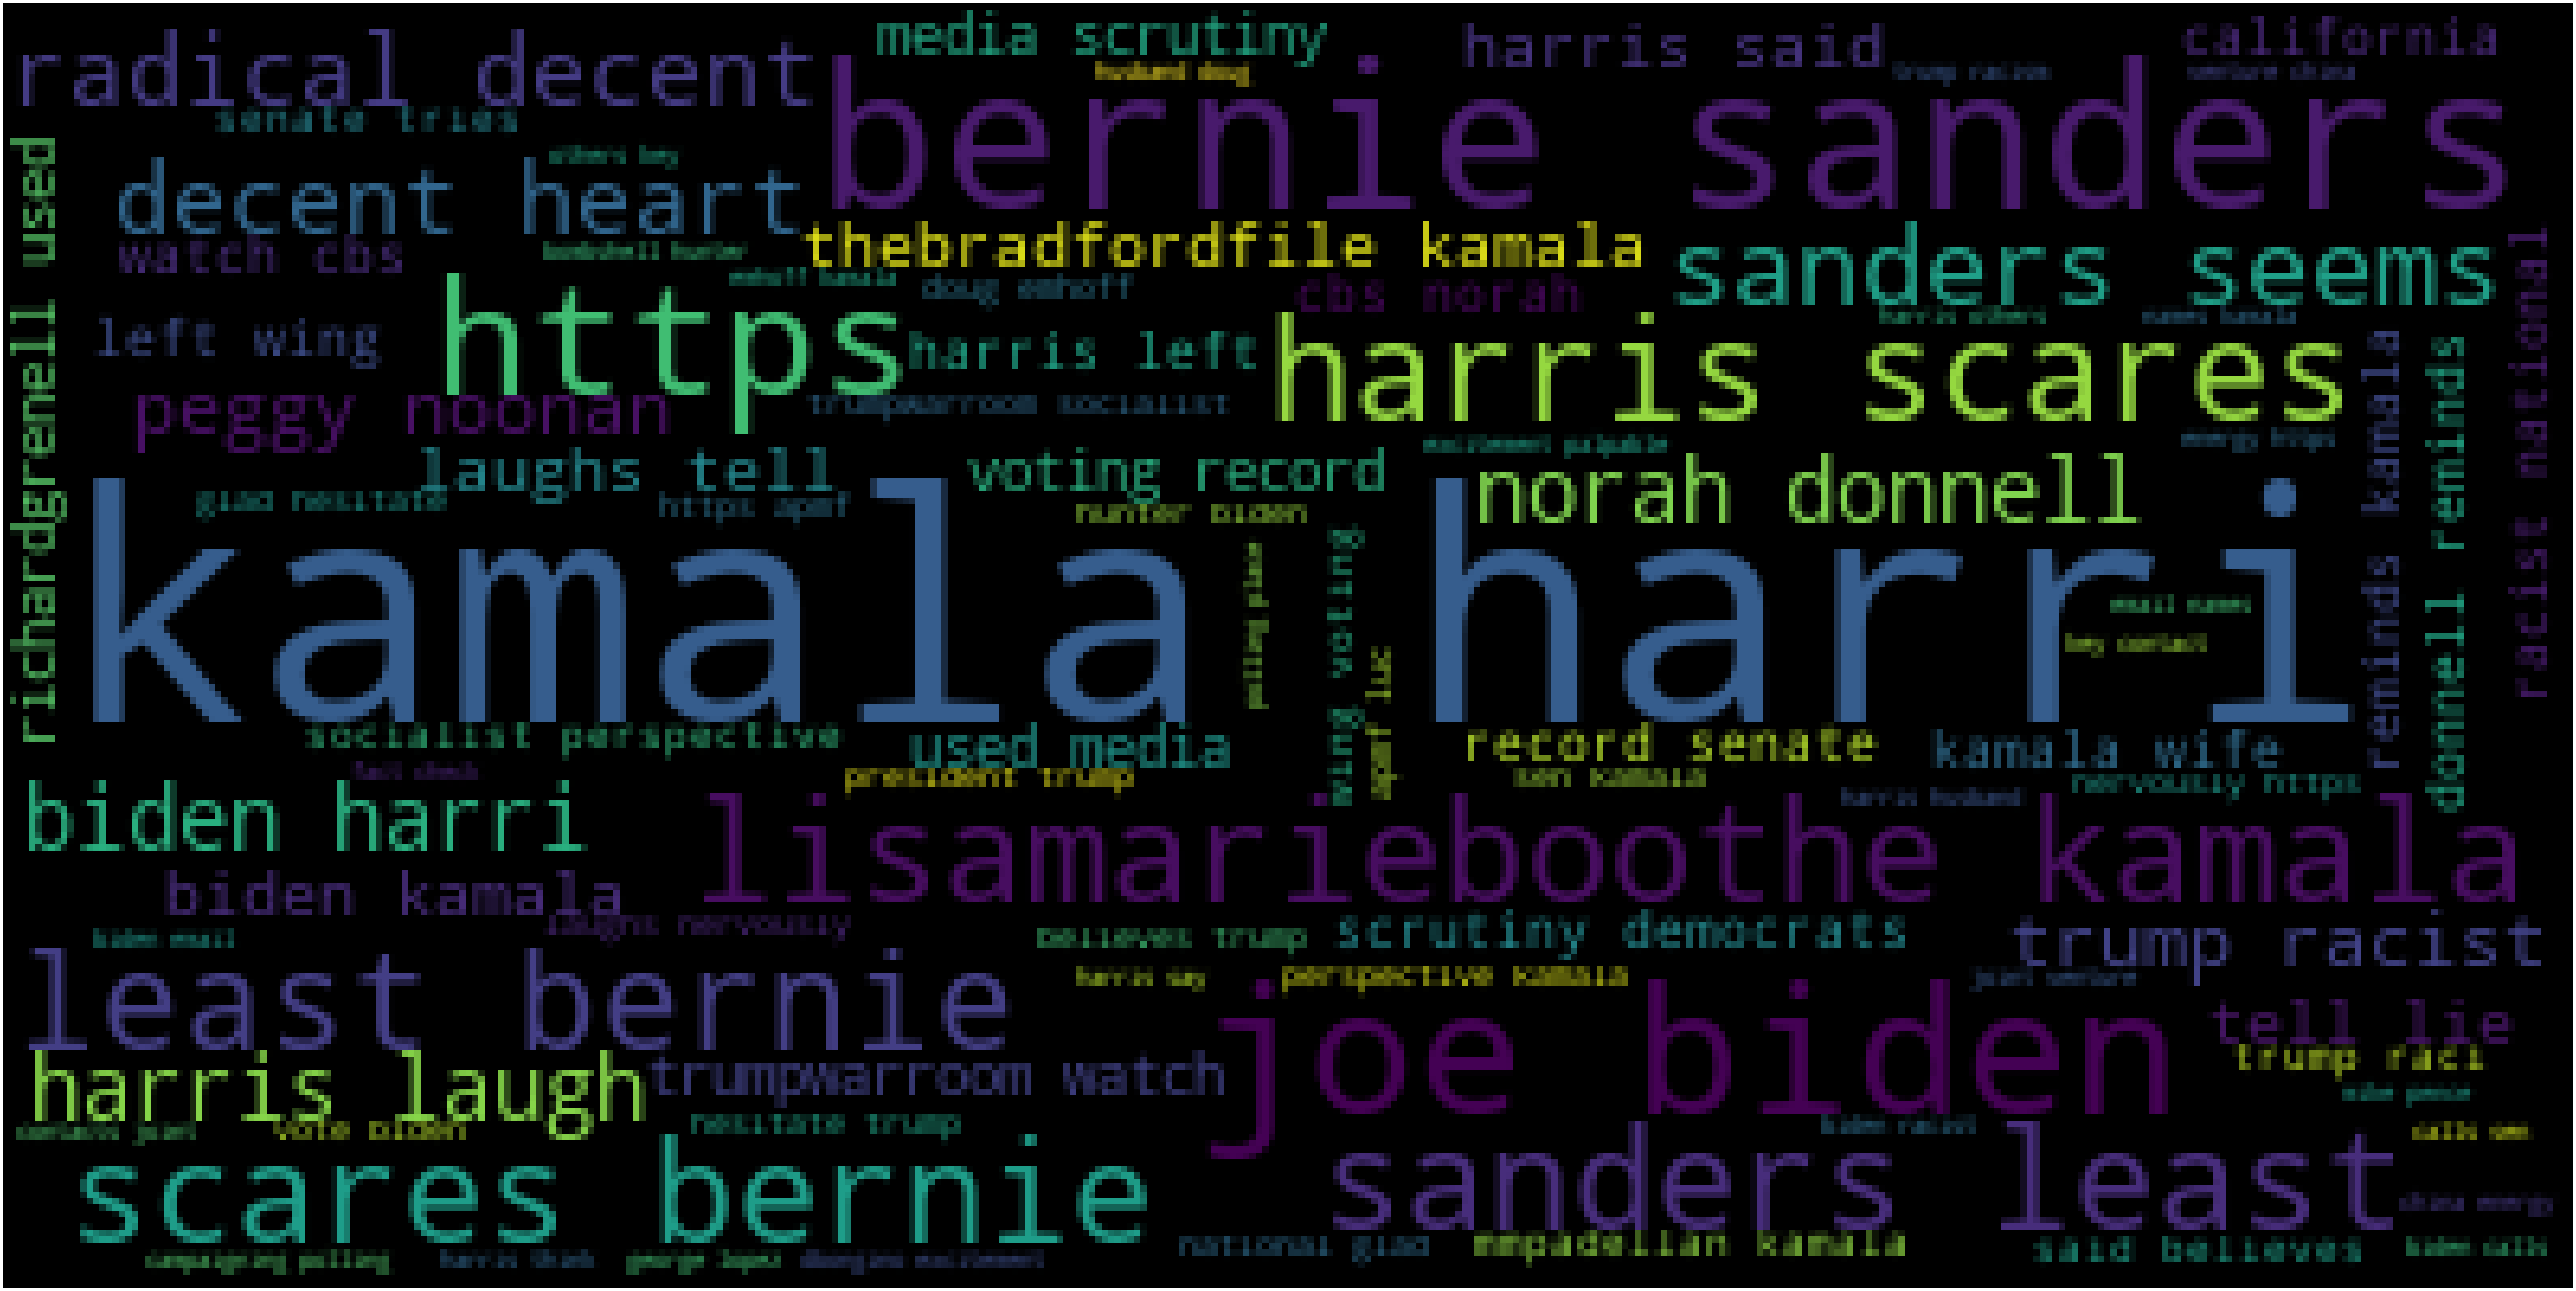

In [21]:
wc(cleaned_data_title,'black','Common Words' )

In [ ]:
from textblob import TextBlob

bloblist_desc = list()

twit=dataset1['text'].astype(str)
for row in twit:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    twit_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
    
def f(twit_polarity_desc):
    if twit_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif twit_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

twit_polarity_desc['Sentiment_Type'] = twit_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=twit_polarity_desc)

In [ ]:
import collections, numpy as np
a=twit_polarity_desc.Sentiment_Type
neut=np.count_nonzero(a == 'Neutral')
pos=np.count_nonzero(a == 'Positive')
neg=np.count_nonzero(a == 'Negative')
popularity='{0:.2f}'.format((((neut*0.5)+(pos)+(neg*0))/(neut+pos+neg))*100)
popularity